In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from bmtk.builder import NetworkBuilder
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)

In [2]:
v1_fraction = 0.05

v1_models = {
  "VisL4": {
    "depth_range": [310.0, 430.0],
    "models": [
      {
        "N": 2384,
        "model_name": "Sst_501282204",
        "cell_line": "i4Sst",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "501282204_glif_lif_asc_config.json"
      },
      {
        "N": 11898,
        "model_name": "Rorb_314642645",
        "cell_line": "e4Rorb",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "314642645_glif_lif_asc_config.json"
      },
      {
        "N": 13728,
        "model_name": "Scnn1a_517982558",
        "cell_line": "e4Scnn1a",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "517982558_glif_lif_asc_config.json"
      },
      {
        "N": 1231,
        "model_name": "Htr3a_474626527",
        "cell_line": "i4Htr3a",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "474626527_glif_lif_asc_config.json"
      },
      {
        "N": 14644,
        "model_name": "other_483018019",
        "cell_line": "e4other",
        "ei": "e",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "483018019_glif_lif_asc_config.json"
      },
      {
        "N": 4461,
        "model_name": "Pvalb_478958894",
        "cell_line": "i4Pvalb",
        "ei": "i",
        "model_type": "point_neuron",
        "model_template": "nest:glif_lif_asc_psc",
        "dynamics_params": "478958894_glif_lif_asc_config.json"
      }
    ]
  }
}

In [3]:
# models = json.load(open('v1_models.json', 'r'))

models_df = None
for layer, layer_dict in v1_models.items():
    tmp_df = pd.DataFrame.from_dict(
        layer_dict['models']
    )
    tmp_df['layer'] = layer
    tmp_df['N'] = (v1_fraction*tmp_df['N'].values).astype(int)
    models_df = layer_models_df if None else pd.concat((models_df, tmp_df), ignore_index=True)

print('Total Cells: {}'.format(models_df['N'].sum()))
    
models_df = models_df.sort_values(['layer', 'ei'])
models_df.set_index(['layer', 'ei', 'model_name'])

Total Cells: 2415


N cell_line    model_type         model_template  \
layer ei model_name                                                             
VisL4 e  Rorb_314642645    594    e4Rorb  point_neuron  nest:glif_lif_asc_psc   
         Scnn1a_517982558  686  e4Scnn1a  point_neuron  nest:glif_lif_asc_psc   
         other_483018019   732   e4other  point_neuron  nest:glif_lif_asc_psc   
      i  Sst_501282204     119     i4Sst  point_neuron  nest:glif_lif_asc_psc   
         Htr3a_474626527    61   i4Htr3a  point_neuron  nest:glif_lif_asc_psc   
         Pvalb_478958894   223   i4Pvalb  point_neuron  nest:glif_lif_asc_psc   

                                              dynamics_params  
layer ei model_name                                            
VisL4 e  Rorb_314642645    314642645_glif_lif_asc_config.json  
         Scnn1a_517982558  517982558_glif_lif_asc_config.json  
         other_483018019   483018019_glif_lif_asc_config.json  
      i  Sst_501282204     501282204_glif_lif_asc_config.json  
         Htr3a_474626527   474626527_glif_lif_asc_config.json  
         Pvalb_478958894   478958894_glif_lif_asc_config.json

In [4]:
def generate_column_positions(n_cells, depth_range, radial_range):
    radius_outer = radial_range[1]
    radius_inner = radial_range[0]
    
    phi = 2.0 * np.pi * np.random.random(n_cells)
    r = np.sqrt((radius_outer**2 - radius_inner**2)*np.random.random(n_cells) + radius_inner**2)
    x = r * np.cos(phi)
    z = r * np.sin(phi)
    y = (depth_range[1] - depth_range[0]) * np.random.random(n_cells) + depth_range[0]
    return x, y, z


In [5]:
# recurrent connectivity code comes here
cc_prob_dict = json.load(open("v1_conn_props.json", "r"))

def compute_pair_type_parameters(source_type, target_type):
    src_new = source_type[3:] if source_type[0:3] == "LIF" else source_type
    trg_new = target_type[3:] if target_type[0:3] == "LIF" else target_type

    src_tmp = src_new[0:2]
    if src_new[0] == "i":
        src_tmp = src_new[0:3]
    if src_new[0:2] == "i2":
        src_tmp = src_new[0:2] + src_new[3]

    trg_tmp = trg_new[0:2]
    if trg_new[0] == "i":
        trg_tmp = trg_new[0:3]
    if trg_new[0:2] == "i2":
        trg_tmp = trg_new[0:2] + trg_new[3]

    cc_props = cc_prob_dict[src_tmp + "-" + trg_tmp]

    # A_literature is different for every source-target pair and was estimated from the literature.
    A_literature = cc_props["A_literature"]

    # R0 read from the dictionary, but setting it now at 75um for all cases but this allows us to change it
    R0 = cc_props["R0"]

    # Sigma is measure from the literature or internally at the Allen Institute
    sigma = cc_props["sigma"]

    # Gaussian equation was intergrated to and solved to calculate new A_new. See accompanying documentation.
    A_new = A_literature / ((sigma / R0) ** 2 * (1 - np.exp(-((R0 / sigma) ** 2))))

    # Due to the measured values in the literature being from multiple sources and approximations that were
    # made by us and the literature (for instance R0 = 75um and sigma from the literature), we found that it is
    # possible for A_new to go slightly above 1.0 in which case we rescale it to 1.0. We confirmed that if this
    # does happen, it is for a few cases and is not much higher than 1.0.
    if A_new > 1.0:
        A_new = 1.0

    ##### To include orientation tuning ####
    # Many cells will show orientation tuning and the relative different in orientation tuning angle will influence
    # probability of connections as has been extensively report in the literature. This is modeled here with a linear
    # where B in the largest value from 0 to 90 (if the profile decays, then B is the intercept, if the profile
    # increases, then B is the value at 90). The value of G is the gradient of the curve.
    # The calculations and explanation can be found in the accompanying documentation with this code.

    # Extract the values from the dictionary for B, the maximum value and G the gradient
    B_ratio = cc_props["B_ratio"]
    B_ratio = np.nan if B_ratio is None else B_ratio

    # Check if there is orientation dependence in this source-target pair type. If yes, then a parallel calculation
    # to the one done above for distance dependence is made though with the assumption of a linear profile.
    if not np.isnan(B_ratio):
        # The scaling for distance and orientation must remain less than 1 which is calculated here and reset
        # if it is greater than one. We also ensure that the area under the p(delta_phi) curve is always equal
        # to one (see documentation). Hence the desired ratio by the user may not be possible, in which case
        # an warning message appears indicating the new ratio used. In the worst case scenario the line will become
        # horizontal (no orientation tuning) but will never "reverse" slopes.

        # B1 is the intercept which occurs at (0, B1)
        # B2 is the value when delta_phi equals 90 degree and hence the point (90, B2)
        B1 = 2.0 / (1.0 + B_ratio)
        B2 = B_ratio * B1

        AB = A_new * max(B1, B2)
        if AB > 1.0:
            if B1 >= B2:
                B1_new = 1.0 / A_new
                delta = B1 - B1_new
                B1 = B1_new
                B2 = B2 + delta
            elif B2 > B1:
                B2_new = 1.0 / A_new
                delta = B2 - B2_new
                B2 = B2_new
                B1 = B1 + delta

            B_ratio = B2 / B1

        G = (B2 - B1) / 90.0

    # If there is no orientation dependent, record this by setting the intercept to Not a Number (NaN).
    else:
        B1 = np.NaN
        G = np.NaN

    # Return the dictionary. Note, the new values are A_new and intercept. The rest are from CC_prob_dict.
    return {
        "A_new": A_new,
        "sigma": sigma,
        "gradient": G,
        "intercept": B1,
        "nsyn_range": cc_props["nsyn_range"],
    }


def connect_cells(sources, target, params):
    sources_x = np.array([s["x"] for s in sources])
    sources_z = np.array([s["z"] for s in sources])
    sources_tuning_angle = [s["tuning_angle"] for s in sources]

    # Get target id
    tid = target.node_id
    # Read parameter values needed for distance and orientation dependence
    A_new = params["A_new"]
    sigma = params["sigma"]
    gradient = params["gradient"]
    intercept = params["intercept"]
    nsyn_range = params["nsyn_range"]

    # Calculate the intersomatic distance between the current two cells (in 2D - not including depth)
    intersomatic_distance = np.sqrt(
        (sources_x - target["x"]) ** 2 + (sources_z - target["z"]) ** 2
    )

    ### Check if there is orientation dependence
    if not np.isnan(gradient):
        # Calculate the difference in orientation tuning between the cells
        delta_orientation = np.array(sources_tuning_angle, dtype=float) - float(
            target["tuning_angle"]
        )

        # For OSI, convert to quadrant from 0 - 90 degrees
        delta_orientation = abs(abs(abs(180.0 - abs(delta_orientation)) - 90.0) - 90.0)

        # Calculate the probability two cells are connected based on distance and orientation
        p_connect = (
            A_new
            * np.exp(-((intersomatic_distance / sigma) ** 2))
            * (intercept + gradient * delta_orientation)
        )

    ### If no orienatation dependence
    else:
        # Calculate the probability two cells are connection based on distance only
        p_connect = A_new * np.exp(-((intersomatic_distance / sigma) ** 2))

    # If not the same cell (no self-connections)
    if 0.0 in intersomatic_distance:
        p_connect[np.where(intersomatic_distance == 0.0)[0][0]] = 0

    # Decide which cells get a connection based on the p_connect value calculated
    p_connected = np.random.binomial(1, p_connect)
    p_connected[p_connected == 1] = np.random.randint(
        nsyn_range[0], nsyn_range[1], len(p_connected[p_connected == 1])
    )

    nsyns_ret = [Nsyn if Nsyn != 0 else None for Nsyn in p_connected]
    return nsyns_ret


def find_direction_rule(src_label, trg_label):
    src_ei = 'e' if src_label.startswith('e') or src_label.startswith('LIFe') else 'i'
    trg_ei = 'e' if trg_label.startswith('e') or trg_label.startswith('LIFe') else 'i'

    if src_ei == 'e' and trg_ei == 'e':
        return 'DirectionRule_EE', 30.0

    elif src_ei == 'e' and trg_ei == 'i':
        return 'DirectionRule_others', 90.0

    elif src_ei =='i' and trg_ei == 'e':
        return 'DirectionRule_others', 90.0

    else:
        return 'DirectionRule_others', 50.0



def add_v1_v1_edges(net, edge_props_path='v1_edge_models.csv'):
    conn_weight_df = pd.read_csv(edge_props_path, sep=' ')

    for _, row in conn_weight_df.iterrows():
        node_type_id = row['target_model_id']
        src_type = row['source_label']
        trg_type = row['target_label']
        
        trg_model_name = trg_type[2:] + '_' + str(node_type_id)
        src_trg_params = compute_pair_type_parameters(src_type, trg_type)

        weight_fnc, weight_sigma = find_direction_rule(src_type, trg_type)
        if src_trg_params['A_new'] > 0.0:
            net.add_edges(
                edge_type_id=row['edge_type_id'],
                source={'cell_line': src_type},
                # target={'node_type_id': node_type_id},
                target={'model_name': trg_model_name},
                iterator='all_to_one',
                connection_rule=connect_cells,
                connection_params={'params': src_trg_params},
                dynamics_params=row['params_file'],
                syn_weight=row['weight_max'],
                delay=row['delay'],
                weight_function=weight_fnc,
                weight_sigma=weight_sigma,
                model_template='static_synapse'
            )
    return net







In [7]:
np.random.seed(1234)
v1 = NetworkBuilder('v1')

outer_radius = 845.0 * np.sqrt(v1_fraction)
radial_range = (1.0, outer_radius)

for layer, layer_dict in v1_models.items():
    depth_range = layer_dict['depth_range']
    for model_props in layer_dict['models']:
        n_cells = int(model_props['N']*v1_fraction)
        x, y, z = generate_column_positions(n_cells, depth_range=depth_range, radial_range=radial_range)
        v1.add_nodes(
            N=n_cells,
            layer=layer,       
            x=x,
            y=y,
            z=z,
            tuning_angle=np.linspace(0.0, 360.0, n_cells),
            model_name=model_props['model_name'],
            cell_line=model_props['cell_line'],
            ei=model_props['ei'],
            model_type=model_props['model_type'],
            model_template=model_props['model_template'],
            dynamics_params=model_props['dynamics_params']
        )
        
v1 = add_v1_v1_edges(v1)
v1.build()
v1.save(output_dir='network')

In [8]:
def positions_grids(n_cells, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    """Randomly generate x, y positions on a screen/rectangle of given "size" divided into evenly sized
    grids. The number of cells in each grid will be evenly distributed += 1 cell. But within each grid 
    the distribution of coordinates are randomized.
    """
    
    n_grids = x_grids*y_grids
    tile_width = size[0]/x_grids
    tile_height = size[1]/y_grids

    # Keeps track of the total number of cells in each grid evenly divided, if n_cells is not divisible
    #  by n_grids then randomly distribute the remaining cells into different grids
    grid_cell_counts = np.full(y_grids*x_grids, int(n_cells/n_grids))
    grid_remainder = n_cells % n_grids
    if grid_remainder != 0:
        rand_idxs = np.random.choice(range(len(grid_cell_counts)), size=grid_remainder, replace=False)
        grid_cell_counts[rand_idxs] += 1
    grid_cell_counts = grid_cell_counts.reshape((x_grids, y_grids))
    
    # for each grid generate random coordinates
    xs = np.zeros(n_cells)
    ys = np.zeros(n_cells)
    x_indx, y_indx = 0, 0
    for i in range(x_grids):
        for j in range(y_grids):
            n = grid_cell_counts[i, j]           
            xs[x_indx:(x_indx+n)] = np.random.uniform(i*tile_width, (i+1)*tile_width, n)
            ys[y_indx:(y_indx+n)] = np.random.uniform(j*tile_height, (j+1)*tile_height, n)
            x_indx += n
            y_indx += n
    
    return xs, ys


def plot_grids(lgn_net, x_grids=15, y_grids=10, size=(240.0, 120.0)):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    lgn_df = pd.DataFrame({
        'model_name': [n['model_name'] for n in lgn_net.nodes()],
        'x': [n['x'] for n in lgn_net.nodes()],
        'y': [n['y'] for n in lgn_net.nodes()],
    })
    for model_name, model_df in lgn_df.groupby('model_name'):
        ax.scatter(model_df['x'].values, model_df['y'].values, s=10, label=model_name)
    
    ax.set_xticks(np.arange(0, size[0]+x_grids, size[0]/x_grids))
    ax.set_yticks(np.arange(0, size[1]+y_grids, size[1]/y_grids))
    ax.legend()
    ax.grid()


## Feedforward inputs from LGN


#### LGN cell models

In [9]:
x_grids, y_grids = 15, 10
field_size = (240.0, 120.0)
lgn_fraction = 1.0

lgn_models = {
  "sON_TF1": {
    "N": 1050,
    # "model_name": "sON_TF1",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF1",
    "dynamics_params": "sON_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF2": {
    "N": 750,
    # "model_name": "sON_TF2",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF2",
    "dynamics_params": "sON_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF4": {
    "N": 1050,
    # "model_name": "sON_TF4",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF4",
    "dynamics_params": "sON_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sON_TF8": {
    "N": 2250,
    # "model_name": "sON_TF8",
    "subtype": "sON",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sON_TF8",
    "dynamics_params": "sON_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF1": {
    "N": 1200,
    # "model_name": "sOFF_TF1",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF1",
    "dynamics_params": "sOFF_TF1.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF2": {
    "N": 1200,
    # "model_name": "sOFF_TF2",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF2",
    "dynamics_params": "sOFF_TF2.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF4": {
    "N": 2250,
    # "model_name": "sOFF_TF4",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF4",
    "dynamics_params": "sOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF8": {
    "N": 1200,
    # "model_name": "sOFF_TF8",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF8",
    "dynamics_params": "sOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sOFF_TF15": {
    "N": 1050,
    # "model_name": "sOFF_TF15",
    "subtype": "sOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sOFF_TF15",
    "dynamics_params": "sOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF4": {
    "N": 1500,
    # "model_name": "tOFF_TF4",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF4",
    "dynamics_params": "tOFF_TF4.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF8": {
    "N": 750,
    # "model_name": "tOFF_TF8",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF8",
    "dynamics_params": "tOFF_TF8.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "tOFF_TF15": {
    "N": 1200,
    # "model_name": "tOFF_TF15",
    "subtype": "tOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:tOFF_TF15",
    "dynamics_params": "tOFF_TF15.json",
    "size_range": [2, 10],
    "tuning_angle": False
  },
  "sONsOFF_001": {
    "N": 1200,
    # "model_name": "sONsOFF_001",
    "subtype": "sONsOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONsOFF_001",
    "dynamics_params": "sOFF_TF4.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [6, 6],
    "sf_sep": 6.0,
    "tuning_angle": True
  },
  "sONtOFF_001": {
    "N": 750,
    # "model_name": "sONtOFF_001",
    "subtype": "sONtOFF",
    # "ei": "e",
    "model_type": "virtual",
    "model_template": "lgnmodel:sONtOFF_001",
    "dynamics_params": "tOFF_TF8.json",
    "non_dom_params": "sON_TF4.json",
    "size_range": [9, 9],
    "sf_sep": 4.0,
    "tuning_angle": True
  }
}

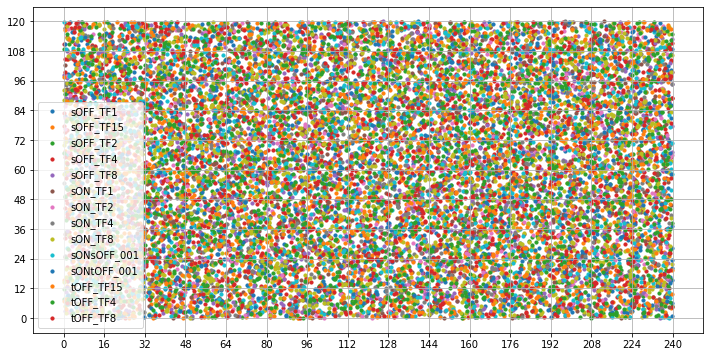

In [10]:
# lgn_models = json.load(open('lgn_models.json', 'r'))
# 

# for reproducibility of the LGN cell locations, 
# so that we don't need to run the LGN simualtions when the model is rebuilt
np.random.seed(12345)

lgn = NetworkBuilder('lgn')
for model_name, params in lgn_models.items():
    n_cells = int(params['N']*lgn_fraction)
    x, y = positions_grids(n_cells, x_grids=x_grids, y_grids=y_grids, size=field_size)
    size_range = params['size_range']
    lgn.add_nodes(
        N=params['N'],
        model_name=model_name,
        subtype=params['subtype'],
        model_type=params['model_type'],
        model_template=params['model_template'],
        dynamics_params=params['dynamics_params'],
        non_dom_params=params.get('non_dom_params', None),
        x=x,
        y=y,
        tuning_angle=[np.NaN]*n_cells if params['tuning_angle'] else np.linspace(0.0, 360.0, n_cells),
        spatial_size=np.random.uniform(size_range[0], size_range[1], n_cells),
        sf_sep=params.get('sf_sep', None),
        jitter_lower=0.975,
        jitter_upper=1.025
    )

plot_grids(lgn, x_grids=x_grids, y_grids=y_grids, size=field_size)

In [11]:
lgn_connections = {
  "e4Nr5a1": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5272113965417778,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4Rorb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.518666852825,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4Scnn1a": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5173743580285,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "e4other": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.9,
      "centers_d_min": 4.0,
      "centers_d_max": 6.0,
      "ON_OFF_w_min": 7.5,
      "ON_OFF_w_max": 9.5,
      "aspectRatio_min": 3.4,
      "aspectRatio_max": 3.6,
      "N_syn": 80
    },
    "edge_types_params": {
      "syn_weight": 0.5152488843942,
      "delay": 1.7,
      "dynamics_params": "e2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Htr3a": {
    "connection_params": {
      "probability": 0.444,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 20
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Pvalb": {
    "connection_params": {
      "probability": 1.0,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 10.0,
      "ON_OFF_w_max": 13.0,
      "aspectRatio_min": 1.6,
      "aspectRatio_max": 1.8,
      "N_syn": 75
    },
    "edge_types_params": {
      "syn_weight": 1.7916764292750003,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  },
  "i4Sst": {
    "connection_params": {
      "probability": 0.333,
      "poissonParameter": 2.0,
      "sON_ratio": 0.75,
      "centers_d_min": 6.0,
      "centers_d_max": 10.0,
      "ON_OFF_w_min": 8.5,
      "ON_OFF_w_max": 11.0,
      "aspectRatio_min": 2.2,
      "aspectRatio_max": 2.4,
      "N_syn": 25
    },
    "edge_types_params": {
      "syn_weight": 0.0,
      "delay": 1.7,
      "dynamics_params": "i2e.json",
      "model_template": "static_synapse"
    }
  }
}

In [12]:
def get_selection_probability(src_type, lgn_models_subtypes_dictionary):
    current_model_subtypes = lgn_models_subtypes_dictionary[src_type[0:4]]['sub_types']
    current_model_probabilities = lgn_models_subtypes_dictionary[src_type[0:4]]['probabilities']
    lgn_model_idx = [i for i, model in enumerate(current_model_subtypes) if src_type == model][0]
    return current_model_probabilities[lgn_model_idx]


def select_lgn_sources(sources, target, lgn_mean, probability, poissonParameter, sON_ratio, centers_d_min,
                       centers_d_max, ON_OFF_w_min, ON_OFF_w_max, aspectRatio_min, aspectRatio_max, N_syn):
    source_ids = [s.node_id for s in sources]

    # Check if target supposed to get a connection and if not, then no need to keep calculating.
    if np.random.random() > probability:
        return [None]*len(source_ids)

    subfields_centers_distance_L = centers_d_max - centers_d_min
    subfields_ON_OFF_width_L = ON_OFF_w_max - ON_OFF_w_min
    subfields_width_aspect_ratio_L = aspectRatio_max - aspectRatio_min

    x_position_lin_degrees = np.tan(0.07*np.array(target['x'])*np.pi/180.0)*180.0/np.pi
    y_position_lin_degrees = np.tan(0.04*np.array(target['z'])*np.pi/180.0)*180.0/np.pi

    vis_x = lgn_mean[0] + ((x_position_lin_degrees))  # - l4_mean[0]) / l4_dim[0]) * lgn_dim[0]
    vis_y = lgn_mean[1] + ((y_position_lin_degrees))  # - l4_mean[2]) / l4_dim[2]) * lgn_dim[1]

    ellipse_center_x0 = vis_x  # tar_cells[tar_gid]['vis_x']
    ellipse_center_y0 = vis_y  # tar_cells[tar_gid]['vis_y']

    tuning_angle = float(target['tuning_angle'])
    tuning_angle = None if np.isnan(tuning_angle) else tuning_angle
    #tuning_angle = None if math.isnan(target['tuning_angle']) else target['tuning_angle']
    if tuning_angle is None:
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0) * subfields_ON_OFF_width_L) / 2.0  # Divide by 2 to convert from width to radius.
        ellipse_b0 = 2.5 * ellipse_b0  # 1.5 * ellipse_b0
        ellipse_a0 = ellipse_b0  # ellipse_b0
        top_N_src_cells_subfield = 15  # 20
        ellipses_centers_halfdistance = 0.0
        tuning_angle_value = 0.0
    else:
        tuning_angle_value = float(tuning_angle)
        ellipses_centers_halfdistance = (centers_d_min + np.random.uniform(0.0, 1.0)* subfields_centers_distance_L) / 2.0
        ellipse_b0 = (ON_OFF_w_min + np.random.uniform(0.0, 1.0) * subfields_ON_OFF_width_L) / 2.0  # Divide by 2 to convert from width to radius.
        ellipse_a0 = ellipse_b0 * (aspectRatio_min + np.random.uniform(0.0, 1.0) * subfields_width_aspect_ratio_L)
        ellipse_phi = tuning_angle_value + 180.0 + 90.0  # Angle, in degrees, describing the rotation of the canonical ellipse away from the x-axis.
        ellipse_cos_mphi = np.cos(-np.radians(ellipse_phi))
        ellipse_sin_mphi = np.sin(-np.radians(ellipse_phi))
        top_N_src_cells_subfield = 8  # 10 #9

        if np.random.random() < sON_ratio:
            cell_sustained_unit = 'sON_'
        else:
            cell_sustained_unit = 'sOFF_'

    cell_TF = np.random.poisson(poissonParameter)
    while cell_TF <= 0:
        cell_TF = np.random.poisson(poissonParameter)

    sON_subunits = np.array([1., 2., 4., 8.])
    sON_sum = np.sum(abs(cell_TF - sON_subunits))
    p_sON = (1 - abs(cell_TF - sON_subunits) / sON_sum) / (len(sON_subunits) - 1)

    sOFF_subunits = np.array([1., 2., 4., 8., 15.])
    sOFF_sum = np.sum(abs(cell_TF - sOFF_subunits))
    p_sOFF = (1 - abs(cell_TF - sOFF_subunits) / sOFF_sum) / (len(sOFF_subunits) - 1)

    tOFF_subunits = np.array([4., 8., 15.])
    tOFF_sum = np.sum(abs(cell_TF - tOFF_subunits))
    p_tOFF = (1 - abs(cell_TF - tOFF_subunits) / tOFF_sum) / (len(tOFF_subunits) - 1)

    # to match previous algorithm reorganize source cells by type
    cell_type_dict = {}
    for lgn_model in lgn_models:
        cell_type_dict[lgn_model] = [(src.node_id, src) for src in sources if src['model_name'] == lgn_model]


    lgn_models_subtypes_dictionary = {
        'sON_': {'sub_types': ['sON_TF1', 'sON_TF2', 'sON_TF4', 'sON_TF8'], 'probabilities': p_sON},
        'sOFF': {'sub_types': ['sOFF_TF1', 'sOFF_TF2', 'sOFF_TF4', 'sOFF_TF8', 'sOFF_TF15'], 'probabilities': p_sOFF},
        'tOFF': {'sub_types': ['tOFF_TF4', 'tOFF_TF8', 'tOFF_TF15'], 'probabilities': p_tOFF},
    }

    src_cells_selected = {}
    for src_type in cell_type_dict.keys():
        src_cells_selected[src_type] = []

        if tuning_angle is None:
            ellipse_center_x = ellipse_center_x0
            ellipse_center_y = ellipse_center_y0
            ellipse_a = ellipse_a0
            ellipse_b = ellipse_b0
        else:
            if ('tOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 + ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 + ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            elif ('sON_' in src_type[0:5] or 'sOFF_' in src_type[0:5]):
                ellipse_center_x = ellipse_center_x0 - ellipses_centers_halfdistance * ellipse_sin_mphi
                ellipse_center_y = ellipse_center_y0 - ellipses_centers_halfdistance * ellipse_cos_mphi
                ellipse_a = ellipse_a0
                ellipse_b = ellipse_b0
            else:
                # Make this a simple circle.
                ellipse_center_x = ellipse_center_x0
                ellipse_center_y = ellipse_center_y0
                # Make the region from which source cells are selected a bit smaller for the transient_ON_OFF cells,
                # since each source cell in this case produces both ON and OFF responses.
                ellipse_b = ellipses_centers_halfdistance/2.0 #0.01 #ellipses_centers_halfdistance + 1.0*ellipse_b0 #0.01 #0.5 * ellipse_b0 # 0.8 * ellipse_b0
                ellipse_a = ellipse_b0 #0.01 #ellipse_b0

        # Find those source cells of the appropriate type that have their visual space coordinates within the ellipse.
        for src_id, src_dict in cell_type_dict[src_type]:
            x, y = (src_dict['x'], src_dict['y'])
            x = x - ellipse_center_x
            y = y - ellipse_center_y

            x_new = x
            y_new = y
            if tuning_angle is not None:
                x_new = x * ellipse_cos_mphi - y * ellipse_sin_mphi
                y_new = x * ellipse_sin_mphi + y * ellipse_cos_mphi

            if ((x_new / ellipse_a) ** 2 + (y_new / ellipse_b) ** 2) <= 1.0:
                if tuning_angle is not None:
                    if src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001':
                        src_tuning_angle = float(src_dict['tuning_angle'])
                        delta_tuning = abs(abs(abs(180.0 - abs(tuning_angle_value - src_tuning_angle) % 360.0) - 90.0) - 90.0)
                        if delta_tuning < 15.0:
                            src_cells_selected[src_type].append(src_id)

                    # elif src_type in ['sONtOFF_001']:
                    #     src_cells_selected[src_type].append(src_id)

                    elif cell_sustained_unit in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                    elif 'tOFF_' in src_type[:5]:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

                else:
                    if (src_type == 'sONsOFF_001' or src_type == 'sONtOFF_001'):
                        src_cells_selected[src_type].append(src_id)
                    else:
                        selection_probability = get_selection_probability(src_type, lgn_models_subtypes_dictionary)
                        if np.random.random() < selection_probability:
                            src_cells_selected[src_type].append(src_id)

    select_cell_ids = [id for _, selected in src_cells_selected.items() for id in selected]
    return [N_syn if id in select_cell_ids else None for id in source_ids]


In [13]:
from datetime import datetime
from datetime import timedelta


for layer, layer_dict in v1_models.items():
    for model_props in layer_dict['models']:
        model_name = model_props['model_name']
        cell_line = model_props['cell_line']
        
        conn_props = lgn_connections[cell_line]['connection_params']
        conn_props['lgn_mean'] = (field_size[0]/2.0, field_size[1]/2.0)
        edge_props = lgn_connections[cell_line]['edge_types_params']
        lgn.add_edges(
            source=lgn.nodes(),
            target=v1.nodes(model_name=model_name),
            connection_rule=select_lgn_sources,
            connection_params=conn_props,
            iterator='all_to_one',
            **edge_props
        )

start_time = datetime.now()
lgn.build()
lgn.save(output_dir='network')
end_time = datetime.now()
print('build time:', timedelta(seconds=(end_time - start_time).total_seconds()))

build time: 0:03:45.677494


### Running the LGN Simulation

#### Gratings inputs

We will start with a moving grating running at a 90 degree angle at a rate of 4.0Hz, with a 500.0 milisecond grey-screen at the start. Update the ```config.simulation_filternet.90deg_4Hz.json``` in the inputs sections:

```json
  "inputs": {
    "gratings": {
      "input_type": "movie",
      "module": "graiting",
      "row_size": 120,
      "col_size": 240,
      "gray_screen_dur": 500.0,
      "cpd": 0.04,
      "temporal_f": 4.0,
      "contrast": 0.8,
      "theta": 90.0,
      "evaluation_options": {
        "downsample": 1,
        "separable": true
      }
    }
  },
```

We can generate gratings input to our lgn cells either through the command line, with access to MPI:

```bash
 $ mpirun -np <N> python run_filternet.py config.simulation_filternet.90deg_4Hz.json
```

or in the jupyter notebook:

In [12]:
from bmtk.simulator import filternet

config = filternet.Config.from_json('config.simulation_filternet.90deg_4Hz.json')
config.build_env()

net = filternet.FilterNetwork.from_config(config)
sim = filternet.FilterSimulator.from_config(config, net)
sim.run()

2022-04-21 13:47:16,966 [WARNING] Directory ./inputs already exists.


2022-04-21 13:47:16,968 [INFO] Created log file


INFO:FilterNetIOUtils:Created log file


2022-04-21 13:47:17,795 [INFO] Building cells.


INFO:FilterNetIOUtils:Building cells.


2022-04-21 13:57:31,740 [INFO] Evaluating rates.


INFO:FilterNetIOUtils:Evaluating rates.


2022-04-21 14:13:55,140 [INFO] Done.


INFO:FilterNetIOUtils:Done.


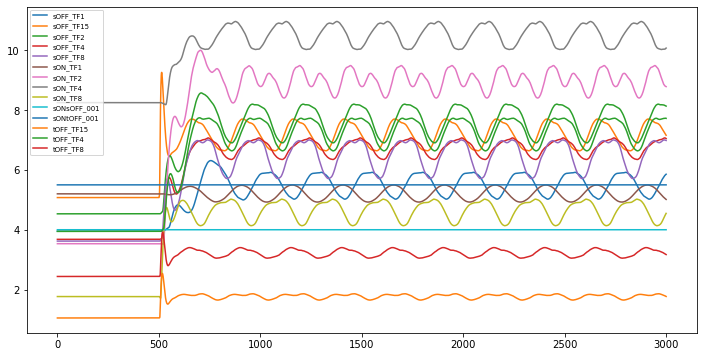

In [13]:
def plot_lgn_firing_rates():
    net = sonata.File(
        data_files='network/lgn_nodes.h5',
        data_type_files='network/lgn_node_types.csv'
    )
    lgn_nodes_df = net.nodes['lgn'].to_dataframe(index_by_id=False)
    lgn_nodes_df = lgn_nodes_df[['node_id', 'model_name']]

    rates_df = pd.read_csv('inputs/rates.gratings.90deg_4Hz.csv', sep=' ')
    rates_df = rates_df.merge(lgn_nodes_df, how='left', on='node_id')
    
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    for model_name, model_df in rates_df.groupby('model_name'):
        rates_tally = None
        n_counts = 0.0
        for _, node_grp in model_df.groupby('node_id'):
            n_counts += 1.0
            rates_tally = node_grp['firing_rates'].values if rates_tally is None else rates_tally + node_grp['firing_rates'].values

        rates_tally /= n_counts
        plt.plot(rates_tally, label=model_name)

    plt.legend(fontsize='x-small')
    plt.show()
    

plot_lgn_firing_rates()

## Background inputs

In [21]:
def add_nodes_bkg():
    bkg = NetworkBuilder('bkg')
    bkg.add_nodes(
        N=1, 
        pop_name='SG_001', 
        ei='e', 
        location='BKG',
        model_type='virtual',
        x=[-91.23767151810344],
        y=[233.43548226294524]
    )
    return bkg
    
def add_bkg_v1_edges(v1_net, bkg_net):
    conn_weight_df = pd.read_csv('bkg_edge_models.csv', sep=' ')

    for _, row in conn_weight_df.iterrows():
        trg_type = row['target_label']
        # target_node_type = row['target_model_id']

        edge_params = {
            'source': bkg_net.nodes(),
            # 'target': v1_net.nodes(node_type_id=target_node_type),
            'target': v1_net.nodes(cell_line=trg_type),
            'connection_rule': lambda s, t, n: n,
            'connection_params': {'n': 100},
            'dynamics_params': row['dynamics_params'],
            'syn_weight': row['syn_weight'],
            'delay': row['delay'],
            'model_template': 'static_synapse'
        }
        bkg_net.add_edges(**edge_params)

    return bkg_net


bkg = add_nodes_bkg()
bkg = add_bkg_v1_edges(v1, bkg)
bkg.build()
bkg.save(output_dir='network')

## Running the L4 Simulation

In [2]:
from bmtk.simulator import pointnet


configure = pointnet.Config.from_json('config.simulation_pointnet.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

[INFO] [2022.4.21 16:19:24 /Users/runner/miniforge3/conda-bld/nest-simulator_1604245545494/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.4.21 16:19:24 /Users/runner/miniforge3/conda-bld/nest-simulator_1604245545494/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.0
 Built: Nov  1 2020 15:52:13

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

2022-04-21 16:19:24,868 [INFO] Created log file
2022-04-21 16:19:24,891 [INFO] Batch processing nodes for v1/0.
2022-04-21 16:19:25,022 [INFO] Batch processing nodes for lgn/0.
2022-04-21 16:19:25,042 [INFO] Setting up output directory
2022-04-21 16:19:25,044 [INFO] Building cells.
2022-04-21 16:19:25

/Users/shinya.ito/modeling/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/shinya.ito/modeling/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/shinya.ito/modeling/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/shinya.ito/modeling/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/Users/shinya.ito/modeling/bmtk/bmtk/simulator/pointnet/gids.py:63: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


2022-04-21 16:19:38,458 [INFO] Network created.


Error: Canceled future for execute_request message before replies were done

2.5


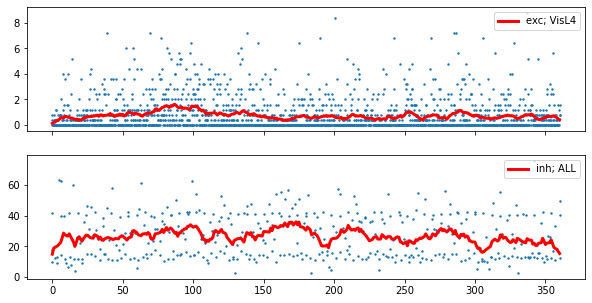

In [34]:
def plot_tunning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), convolv_window=10):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0
    print(dur_secs)

    net = sonata.File(
        data_files='network/v1_nodes.h5',
        data_type_files='network/v1_node_types.csv'
    )
    nodes_df = net.nodes['v1'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]

    spikes = SpikeTrains.load('output/spikes.h5')
    spikes_df = spikes.to_dataframe(population='v1')

    fr_df = spikes_df['node_ids'].value_counts().rename_axis('node_id').to_frame('spike_counts').reset_index()
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)
    fr_df['tuning_rounded'] = 0.0

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        # print(grp_df.index.values)
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if convolv_window and len(fr_avgs['firing_rates']) > convolv_window:
            filter = np.array([1.0] * int(convolv_window)) / float(convolv_window)
            fr_avgs['firing_rates'] = np.convolve(fr_avgs['firing_rates'].values, filter, mode='same')

        ax.plot(fr_avgs['firing_rates'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])

    plt.show()


plot_tunning_angle_fr('output/spikes.h5')

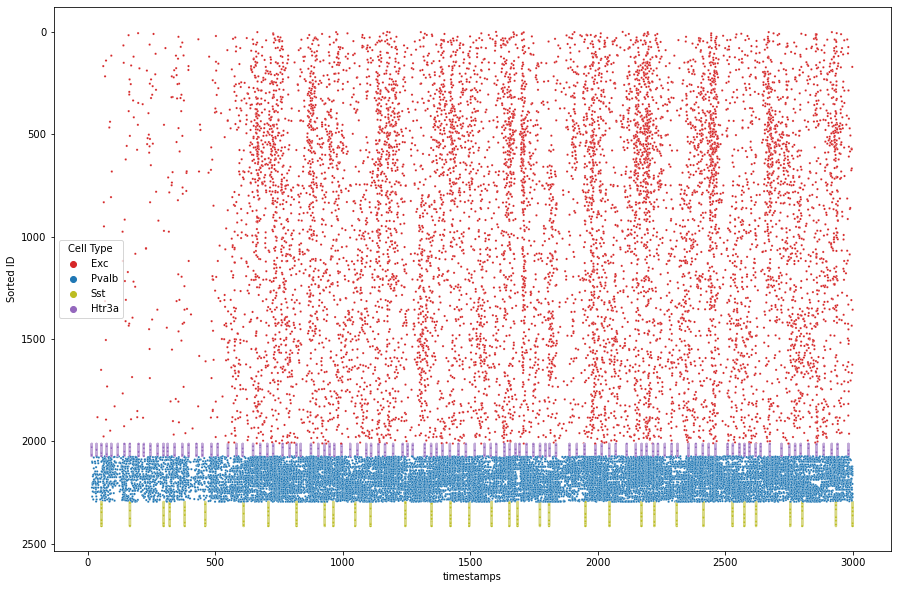

In [25]:
# make a raster plot

import numpy as np
import matplotlib.pyplot as plt
from sonata.circuit import File
import json
import pandas as pd
import re
import seaborn as sns


# in principle, if you provide the config file, you should be able to reproduce all the
# metadata


def read_config(config_file):
    js = json.load(open(config_file, "r"))
    return js


def form_network(config_js):
    # get the network structure out of the simulation
    node_files = [e["nodes_file"] for e in config_js["networks"]["nodes"]]
    # edge_files = [e["edges_file"] for e in config_js["networks"]["edges"]]
    node_type_files = [e["node_types_file"] for e in config_js["networks"]["nodes"]]
    # edge_type_files = [e["edge_types_file"] for e in config_js["networks"]["edges"]]
    net = File(node_files[0], node_type_files[0])
    return net


def get_spikes(config_js):
    spike_file_name = config_js["output"]["spikes_file_csv"]
    spike_df = pd.read_csv(spike_file_name, sep=" ", index_col=2)
    return spike_df


def identify_cell_type(pop_name: str):
    if pop_name.startswith("e"):
        return "Exc"
    else:
        # return the string after the first number
        return re.search(r"\d+(.*)", pop_name).groups()[0]


# this is destructive method (adds columns to v1df)
def determine_sort_position(v1df):
    # reset_v1 = v1df.sort_values(["location", "pop_name", "tuning_angle"]).reset_index()
    reset_v1 = v1df.sort_values(["layer", "Cell Type", "tuning_angle"]).reset_index()
    sort_position = reset_v1.sort_values("index").index
    return sort_position


def plot_raster(config_file, s=1, **kwarg):
    config_js = read_config(config_file)
    net = form_network(config_js)
    spike_df = get_spikes(config_js)

    v1df = net.nodes["v1"].to_dataframe()
    v1df["Cell Type"] = v1df["cell_line"].apply(identify_cell_type)
    v1df["Sort Position"] = determine_sort_position(v1df)

    spike_df["Sorted ID"] = v1df["Sort Position"].loc[spike_df.index]
    spike_df["Cell Type"] = v1df["Cell Type"].loc[spike_df.index]

    hue_order = ["Exc", "Pvalb", "Sst", "Htr3a"]
    color_order = ["tab:red", "tab:blue", "tab:olive", "tab:purple"]
    color_dict = dict(zip(hue_order, color_order))

    ax2 = sns.scatterplot(
        data=spike_df,
        x="timestamps",
        y="Sorted ID",
        hue="Cell Type",
        s=s,
        hue_order=hue_order,
        palette=color_dict,
        **kwarg
    )
    ax2.invert_yaxis()
    return ax2



config_file = "output/config.simulation_pointnet.json"
plt.figure(figsize=(15, 10))
ax = plot_raster(config_file, s=5)